# Beamline 8.3.2 projection alignment

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
from tqdm import tqdm
import numexpr
import numpy as np
from skimage import transform, filters, io, registration
import h5py
import tomopy
import astra
import svmbir
import SimpleITK as sitk
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, FloatSlider, IntSlider
from ipyfilechooser import FileChooser
sys.path.append('../backend')
import ALS_recon_functions as als
use_gpu = als.check_for_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No Nvidia GPU in system, will use CPU


### ITK registration functions

In [2]:
# Helper function used by registration
def applyTx(fixed,moving,tx):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(tx)
    out = resampler.Execute(moving)
    return sitk.GetArrayFromImage(out)

# grid sesarch translation registration
def sitkRegistration_exhaustive(arr_shape,init,steps,scale,down=[4],smooth=[1]):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsExhaustive( numberOfSteps=steps, stepLength=1)
    R.SetOptimizerScales(scale)

    tx = sitk.TranslationTransform(2)

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    R.SetShrinkFactorsPerLevel(down)
    R.SetSmoothingSigmasPerLevel(smooth)
    return R

# translation registration
def sitkRegistration_trans(arr_shape, init, down=[1], smooth=[0]):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()
    # R.SetMetricAsMeanSquares()

    # R.SetOptimizerAsGradientDescent(learningRate=0.1,
    #                                 numberOfIterations=50,
    #                                 convergenceMinimumValue=1e-5)

    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-4,
                                               numberOfIterations=50,
                                               gradientMagnitudeTolerance=1e-8)    
    # R.SetOptimizerScalesFromIndexShift()
    R.SetOptimizerScalesFromJacobian()

    tx = sitk.TranslationTransform(2)
    tx.SetParameters(init)

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    R.SetShrinkFactorsPerLevel(down) # downsample factors, per iteration
    R.SetSmoothingSigmasPerLevel(smooth) # smoothing factors, per iteration

    # R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    return R
# translation/rotation registration
def sitkRegistration_both(arr_shape, init, down=[1], smooth=[0]):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()

    # R.SetOptimizerAsGradientDescent(learningRate=0.1,
    #                                 numberOfIterations=50,
    #                                 convergenceMinimumValue=1e-5)

    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-4,
                                               numberOfIterations=50,
                                               gradientMagnitudeTolerance=1e-8)    
    
    R.SetOptimizerScalesFromIndexShift()
    # R.SetOptimizerScalesFromJacobian()

    # tx = sitk.TranslationTransform(3)
    # tx.SetParameters(init)

    # tx = sitk.EulerTransform()
    tx = sitk.Euler2DTransform()
    tx.SetCenter(np.asarray(arr_shape)/2.0)
    tx.SetTranslation(init)
    # tx.SetParameters(init)

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    # R.SetMetricSamplingPercentage(0.1, sitk.sitkWallClock)
    # R.SetMetricSamplingStrategy(R.REGULAR)

    R.SetShrinkFactorsPerLevel(down) # downsample factors, per iteration
    R.SetSmoothingSigmasPerLevel(smooth) # smoothing factors, per iteration

    # R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    return R

In [3]:
def rot_z(angle):
    rot = np.array([(np.cos(angle), -np.sin(angle), 0.),
                    (np.sin(angle), np.cos(angle), 0.),
                    (0., 0., 1.)])
    return rot
def rot_x(angle):
    rot = np.array([(1., 0., 0.),
                    (0., np.cos(angle), -np.sin(angle)),
                    (0., np.sin(angle), np.cos(angle))])
    return rot

def rot_y(angle):
    rot = np.array([(np.cos(angle), 0., np.sin(angle)),
                    (0., 1., 0.),
                    (-np.sin(angle), 0., np.cos(angle))])
    return rot
def get_astra_projection_vectors(angles,spacing=1.0,dx=0.0,dy=0,alpha=0,beta=0,phi=0):
    vectors = np.zeros((len(angles), 12))
    if isinstance(dx,int) or isinstance(dx,float) or dx.size == 1: dx = dx*np.ones_like(angles) 
    if isinstance(dy,int) or isinstance(dy,float) or dy.size == 1: dy = dy*np.ones_like(angles) 
    if isinstance(alpha,int) or isinstance(alpha,float) or alpha.size == 1: alpha = alpha*np.ones_like(angles) 
    if isinstance(beta,int) or isinstance(beta,float) or beta.size == 1: beta = beta*np.ones_like(angles) 
    if isinstance(phi,int) or isinstance(phi,float) or phi.size == 1: phi = phi*np.ones_like(angles) 
    for i in range(len(angles)):
        # ray direction
        vectors[i,0] = np.sin(angles[i])
        vectors[i,1] = -np.cos(angles[i])
        vectors[i,2] = 0

        # center of detector
        vectors[i,3] = 0
        vectors[i,4] = 0
        vectors[i,5] = 0

        # vector from detector pixel (0,0) to (0,1)
        vectors[i,6] = np.cos(angles[i]) * spacing
        vectors[i,7] = np.sin(angles[i]) * spacing
        vectors[i,8] = 0

        # vector from detector pixel (0,0) to (1,0)
        vectors[i,9] = 0
        vectors[i,10] = 0
        vectors[i,11] = spacing

        # shift center of detector
        vectors[i,3:6] = vectors[i,3:6] + dx[i] * vectors[i,6:9]
        vectors[i,3:6] = vectors[i,3:6] + dy[i] * vectors[i,9:12]

        # rotate by beta
        vectors[i,0:3] = rot_y(beta[i])@vectors[i,0:3]
        vectors[i,6:9] = rot_y(beta[i])@vectors[i,6:9]
        vectors[i,9:12] = rot_y(beta[i])@vectors[i,9:12]

        # rotate by alpha
        vectors[i,0:3] = rot_x(alpha[i])@vectors[i,0:3]
        vectors[i,6:9] = rot_x(alpha[i])@vectors[i,6:9]
        vectors[i,9:12] = rot_x(alpha[i])@vectors[i,9:12]   

        # rotate by phi
        vectors[i,0:3] = rot_z(phi[i])@vectors[i,0:3]
        vectors[i,6:9] = rot_z(phi[i])@vectors[i,6:9]
        vectors[i,9:12] = rot_z(phi[i])@vectors[i,9:12]  
    
    return vectors

### Choose Data

In [6]:
dataDir = "/global/cfs/cdirs/als/users/dperl/bone_data" # where is the raw data
# dataDir = "/global/cfs/cdirs/als/users/dperl/alignment_data/"
file_chooser = FileChooser(dataDir)
file_chooser.filter_pattern = '*.h5' # only show .h5 files
file_chooser.title = f'Choose data file'
display(file_chooser)

FileChooser(path='/global/cfs/cdirs/als/users/dperl/bone_data', filename='', title='Choose data file', show_hi…

### Plot sinograms slices -- does it look misaligned, ie "wavy"

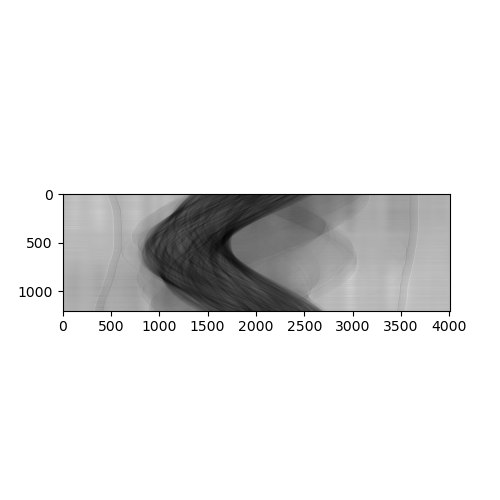

In [7]:
path = file_chooser.selected
metadata = als.read_metadata(path, print_flag = False)
tomo, _ = als.read_data(path, sino=slice(metadata['numslices']//2,metadata['numslices']//2+1), prelog=True)
if plt.fignum_exists(54): plt.close(54)
fig, axs = plt.subplots(1,1,num=54,figsize=(5,5),sharex=True,sharey=True)
img = axs.imshow(np.empty((metadata['numangles'],metadata['numrays'])),cmap='gray')

def set_slice(z):
    tomo, _ = als.read_data(path, sino=slice(z,z+1), prelog=True)
    img.set_data(tomo.squeeze())
def set_clim(clims):
    img.set_clim(vmin=clims[0],vmax=clims[1]) 

slice_slider = widgets.interactive(set_slice, z=widgets.IntSlider(min=0, max=metadata['numslices']-1, step=1, value=metadata['numslices']//2))
clim_slider = widgets.interactive(set_clim, img=widgets.fixed(img),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=tomo.min(), max=tomo.max(),
                                                                   step=(tomo.max()-tomo.min())/500, value=[tomo.min(),tomo.max()]))
     
ui = widgets.VBox([slice_slider, clim_slider])
display(ui)

### Find Center of Rotation (COR)
##### Check COR by manually aligning 0 and 180 degree projections
###### not doing anything with y shift at the moment

20120224_040223_C31R.h5:
numslices: 1879, rays: 4006, numangles: 1201
angularrange: 180.0, pxsize: 1.7799999999999998 um, distance: 0 mm. energy: 0.0 keV


Output()

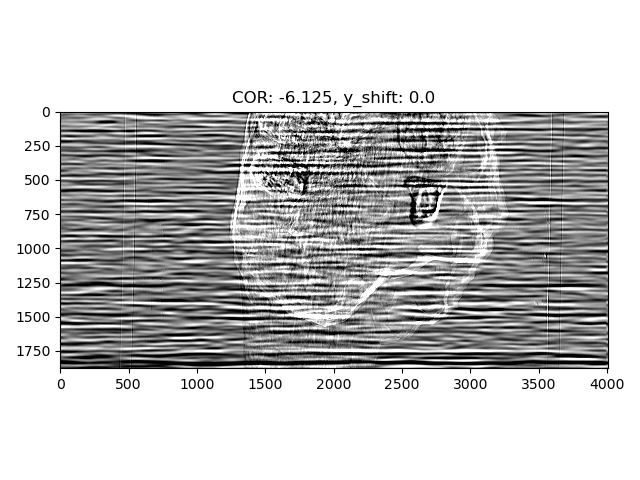

In [11]:
if file_chooser.selected is None:
    print("No datafile selected. Click Select to choose a datafile")
    sys.exit()
metadata = als.read_metadata(file_chooser.selected, print_flag = True)
init_cor, cor_tomo = als.auto_find_cor(file_chooser.selected) # cross-correlation based COR estimate
first_proj, last_proj_flipped = cor_tomo[0], np.fliplr(cor_tomo[1])

axs, img, cor_sliders, cor_out = als.plot_0_and_180_proj_diff(first_proj,
                                                              last_proj_flipped,
                                                              init_cor=init_cor,
                                                              # yshift=True, # shows extra slider to shift proj up/down
                                                              # continuous_update=False # can set continuous update=False to reduce lag (only updates on slider release) 
                                                              fignum=0)
                                                            
display(cor_sliders,cor_out)

### Reconstuct volume with best COR

In [ ]:
%%time
########## parameters ##########
angles_ind = slice(0,-1,2) # get every angle
# slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
# slices_ind = slice(1000,1001)
slices_ind = None
downsample_factor = 8 # must downsample. 8 works, 4 is iffy
fc = 1 # FBP LP filter cutoff: 0-to-1. None is no filtering
COR = cor = cor_sliders.children[0].value # from above
args = { # preprocessing parameters
    'minimum_transmission': 0.01, # threshold for pre-log, normalized sinogram. None turns off
    # for sarepy ring removal
    'snr': 3,  # Sensitivity of stripe detection method. Smaller is more sensitive. Recommended values: 1.1 -> 3.0.
    'la_size': 21, # Window size of the median filter to remove large stripes. Larger is stronger but takes longer. Choose odd value, set to 1 to turn off.
    'sm_size': 11, # Window size of the median filter to remove small stripes. Same advice as above
}
########## dont touch code below ##########
tomo, angles = als.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor, args=args)
print(f"Projection data shape: {tomo.shape}")

### Shift projections on purpose to see if method works 
# shift_max = 5
# shifts = shift_max*(2*np.random.rand(len(angles),2)-1)
# for i, (proj, shift) in enumerate(zip(tomo, shifts)):
#     tomo[i] = als.shift_projections(tomo[i],-shift[0],yshift=-shift[1])

# reconstruct with shifted projector
vectors = get_astra_projection_vectors(-angles,spacing=1.0,dx=-COR/downsample_factor,dy=0)
recon = als.astra_cgls_recon_3d(tomo,vectors,vectors=True)
print(f"Finisehd reconstruction, size: {recon.shape}")
img, axs, clim_slider = als.plot_recon(recon[:5],fignum=3,figsize=4)
slice_slider = widgets.interactive(set_slice, slice_num=IntSlider(min=0, max=len(recon)-1, step=1, value=len(recon)//2),
                                   img=widgets.fixed(img), axs=widgets.fixed(axs), recon=widgets.fixed(recon), slices=widgets.fixed(np.arange(recon.shape[0])))
display(slice_slider)
display(clim_slider)
print('')
print('This took:')

Projection data shape: (600, 235, 501)


### Look at raw projection data and find region that looks easy to register for all projections

In [ ]:
# no mask -- use entire projection 
# y_mask = [slice(0,-1) for _ in range(len(tomo))]
# x_mask = [slice(0,-1) for _ in range(len(tomo))]
# set same mask for all projections
y_mask = [slice(0,200) for _ in range(len(tomo))]
x_mask = [slice(150,350) for _ in range(len(tomo))]
# # set mask that rotates for each projectin
# y_mask = [slice(0,100) for _ in range(len(tomo))]
# x_mask_left = [100,200] # x_start, x_stop
# x_mask_right = [200,300]  # x_start, x_stop
# x_mask = [slice( round(np.interp(np.cos(theta),[-1,1],[x_mask_right[0],x_mask_left[0]])),
#                 round(np.interp(np.cos(theta),[-1,1],[x_mask_right[1],x_mask_left[1]])) )
#           for theta in np.linspace(0,np.pi,num=len(angles),endpoint=False)]
          # for theta in angles]

masked_tomo = np.zeros_like(tomo)
for i in range(len(tomo)):
    masked_tomo[i,y_mask[i],x_mask[i]] = tomo[i,y_mask[i],x_mask[i]]

In [ ]:
if plt.fignum_exists(13): plt.close(13)
fig, axs = plt.subplots(1,1,num=13,figsize=(10, 5),sharex=True,sharey=True)
img0 = axs.imshow(np.empty_like(tomo[0]),cmap='gray',vmin=np.percentile(tomo,1),vmax=np.percentile(tomo,99))
img1 = axs.imshow(np.empty_like(masked_tomo[0]),cmap='viridis',vmin=np.percentile(tomo,1),vmax=np.percentile(tomo,99))
axs.set_title('Colored region will be used for registration')
axs.grid()
plt.tight_layout()

def set_proj(i):
    img0.set_data(tomo[i])
    img1.set_data(tomo[i])
    img1.set_alpha((masked_tomo[i] != 0).astype(float))
def set_clim(img,clims):
    img[0].set_clim(vmin=clims[0],vmax=clims[1]) 
    img[1].set_clim(vmin=clims[0],vmax=clims[1]) 
    
proj_slider = widgets.interactive(set_proj, i=widgets.IntSlider(min=0, max=len(tomo)-1, step=1, value=0))
clim_slider = widgets.interactive(set_clim, img=widgets.fixed([img0, img1]),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=tomo.min(), max=tomo.max(),
                                                                   step=(tomo.max()-tomo.min())/500, value=img0.get_clim()))
     
ui = widgets.VBox([proj_slider, clim_slider])
display(ui)

### Reproject reconstruction

In [ ]:
vol_geom = astra.create_vol_geom(recon.shape[1],recon.shape[2],recon.shape[0])
proj_geom = astra.create_proj_geom('parallel3d_vec', tomo.shape[1], tomo.shape[2], vectors)
_, recon_tomo = astra.create_sino3d_gpu(recon, proj_geom, vol_geom)
recon_tomo = recon_tomo.transpose(1,0,2)
print(recon_tomo.shape)

### Registration function. There are several methods/parameters for registration, can greatly affect quality of results

In [ ]:
# def align_proj(proj, recon_proj):
def align_proj(all_inputs):
    # proj, recon_proj = both_projs # unpack 
    proj, recon_proj, init = all_inputs # unpack 
    fixed = sitk.GetImageFromArray(recon_proj)
    moving = sitk.GetImageFromArray(proj)
    
    # # use exhaustive grid search for initialization
    steps = [5, 5] # number of grid steps in one direction, in x and y -- actually does 2x+1 by 2y+1 search, centered at (0,0)
    scale = [3, 3] # step size, in pixels, in x and y
    down = [1]  # downsample factor, for speed. Can have multiple values, will do them sequentially, initalizing with the previous
    smooth = [3] # (Gaussian?) smoothing factor. Same as down, can have multiple values, will do them sequentially, initalizing with the previous
    R = sitkRegistration_exhaustive(fixed.GetSize(),(0,0),steps,scale,down=down,smooth=smooth)

    tx = R.Execute(fixed, moving)
    params = tx.GetParameters()
    return params

### Align original projections (translation only) to reprojected ones -- this takes the most time

In [ ]:
%%time
params = np.zeros((tomo.shape[0],2)) # initialize with ideal alignment
# params = 10*np.random.randn(tomo.shape[0],2) # initialize with random alignment
masked_tomo = [tomo[i,y_mask[i],x_mask[i]] for i in range(len(tomo))]
masked_recon_tomo = [recon_tomo[i,y_mask[i],x_mask[i]] for i in range(len(tomo))]
all_inputs = zip(masked_tomo,masked_recon_tomo,params)

# serial
# for i,x in tqdm(enumerate(all_inputs),total=len(tomo)):
#     params[i] = align_proj(x)  

# parallelized
with mp.Pool(processes=126) as pool:
    params = np.vstack(tqdm(pool.imap(align_proj, all_inputs), total=len(tomo)))

In [ ]:
params = np.asarray(params)
if plt.fignum_exists(100): plt.close(100)
plt.figure(100)
plt.plot(params[:,0],label='x shift')
plt.plot(params[:,1],label='y shift')
plt.xlabel('Projection')
plt.gca().legend()
plt.show()

### Compare patch registrations -- do they look accurate? 

In [ ]:
aligned_patch = []
for i in tqdm(range(len(tomo))):
    fixed = sitk.GetImageFromArray(recon_tomo[i,y_mask[i],x_mask[i]])
    moving = sitk.GetImageFromArray(tomo[i,y_mask[i],x_mask[i]])
    tx = sitk.TranslationTransform(2)
    tx.SetParameters(params[i])
    aligned_patch.append(applyTx(fixed,moving,tx))

if plt.fignum_exists(24): plt.close(24)
fig, axs = plt.subplots(2,3,num=24,figsize=(5, 5),sharex=True,sharey=True)
img0 = axs[0,0].imshow(recon_tomo[0,y_mask[0],x_mask[0]],cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img1 = axs[1,0].imshow(recon_tomo[0,y_mask[0],x_mask[0]],cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img2 = axs[0,1].imshow(tomo[0,y_mask[0],x_mask[0]],cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img3 = axs[1,1].imshow(aligned_patch[0],cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img4 = axs[0,2].imshow(recon_tomo[0,y_mask[0],x_mask[0]]-tomo[0,y_mask[0],x_mask[0]],cmap='gray',vmin=-0.5,vmax=0.5)
img5 = axs[1,2].imshow(recon_tomo[0,y_mask[0],x_mask[0]]-aligned_patch[0],cmap='gray',vmin=-0.5,vmax=0.5)
axs[0,0].set_title('Fixed (reprojected patch)')
axs[0,1].set_title('Moving')
axs[0,2].set_title('Error')
axs[0,1].set_ylabel('Original Patch')
axs[1,1].set_ylabel('Aligned Patch')
[ax.grid() for ax in axs.flatten()]
plt.suptitle('Aligned patches should have less error than original')
plt.tight_layout()

def set_proj(i):
    img0.set_data(recon_tomo[i,y_mask[i],x_mask[i]])
    img1.set_data(recon_tomo[i,y_mask[i],x_mask[i]])
    img2.set_data(tomo[i,y_mask[i],x_mask[i]])
    img3.set_data(aligned_patch[i])
    img4.set_data(recon_tomo[i,y_mask[i],x_mask[i]]-tomo[i,y_mask[i],x_mask[i]])
    img5.set_data(recon_tomo[i,y_mask[i],x_mask[i]]-aligned_patch[i])

proj_slider = widgets.interactive(set_proj, i=IntSlider(min=0, max=len(tomo)-1, step=1, value=0))

ui = widgets.VBox([proj_slider])
display(ui)

### Reconstruct with alignment info

In [ ]:
# reconstruct with shifted projector
vectors = get_astra_projection_vectors(-angles,spacing=1.0,dx=-COR/downsample_factor-params[:,0],dy=-params[:,1])
proj_geom = astra.create_proj_geom('parallel3d_vec', recon.shape[0], recon.shape[1], vectors)
aligned_recon = als.astra_cgls_recon_3d(tomo,vectors,vectors=True)
_, aligned_recon_tomo = astra.create_sino3d_gpu(aligned_recon, proj_geom, vol_geom)
aligned_recon_tomo = aligned_recon_tomo.transpose(1,0,2)

### Compare raw projections to reprojections, both before and after alignment. Does after alignment look closer? 

In [ ]:
if plt.fignum_exists(4): plt.close(4)
fig, axs = plt.subplots(2,3,num=4,figsize=(5, 5),sharex=True,sharey=True)
img0 = axs[0,0].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img1 = axs[0,1].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img2 = axs[0,2].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=-0.1,vmax=0.1)
img3 = axs[1,0].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img4 = axs[1,1].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img5 = axs[1,2].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=-0.1,vmax=0.1)
axs[0,0].set_title('Original')
axs[0,1].set_title('Reprojected')
axs[0,2].set_title('Error')
axs[0,1].set_ylabel('Before Alignment')
axs[1,1].set_ylabel('After Alignment')
[ax.grid() for ax in axs.flatten()]
plt.tight_layout()

def set_proj(i):
    img0.set_data(tomo[i])
    img1.set_data(recon_tomo[i])
    img2.set_data(tomo[i] - recon_tomo[i])
    img3.set_data(tomo[i])
    img4.set_data(aligned_recon_tomo[i])
    img5.set_data(tomo[i] - aligned_recon_tomo[i])

def set_clim(img,clims):
    for im in img:
        im.set_clim(vmin=clims[0],vmax=clims[1]) 

proj_slider = widgets.interactive(set_proj, i=IntSlider(min=0, max=len(tomo)-1, step=1, value=0))
clim_slider = widgets.interactive(set_clim, img=widgets.fixed([img0, img1, img3, img4]),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=tomo.min(), max=tomo.max(),
                                                                   step=(tomo.max()-tomo.min())/500, value=img0.get_clim()))

ui = widgets.VBox([proj_slider, clim_slider])
display(ui)

### Compare original reconstruction to aligned reconstruction. Does after alignment look better? 

In [ ]:
if plt.fignum_exists(5): plt.close(5)
fig, axs = plt.subplots(1,2,num=5,figsize=(5,5),sharex=True,sharey=True)
img00 = axs[0].imshow(recon[0],cmap='gray',vmin=recon.min(),vmax=recon.max())
axs[0].set_title('original')
img11 = axs[1].imshow(aligned_recon[0],cmap='gray',vmin=recon.min(),vmax=recon.max())
axs[1].set_title('aligned')

plt.tight_layout()

def set_slice(i):
    img00.set_data(recon[i])
    img11.set_data(aligned_recon[i])
    plt.suptitle(f"Slice {i}")

def set_clim(img,clims):
    img[0].set_clim(vmin=clims[0],vmax=clims[1]) 
    img[1].set_clim(vmin=clims[0],vmax=clims[1]) 
    
slice_slider = widgets.IntSlider(min=0, max=len(recon)-1, step=1, value=len(recon)//2)
clim_slider = widgets.interactive(set_clim, img=widgets.fixed([img00, img11]),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=recon.min(), max=recon.max(),
                                                                   step=(recon.max()-recon.min())/500, value=img0.get_clim()))
        
sliders = widgets.interactive_output(set_slice,{'i':slice_slider})
ui = widgets.VBox([slice_slider, clim_slider])
display(sliders,ui)

print('')
print('This took:')

### Do a few iterations (improvement seems to tail off at first one)

In [ ]:
# get ready for new iteration
recon = aligned_recon
recon_tomo = aligned_recon_tomo

#def align_proj(proj, recon_proj,init):
def align_proj(all_inputs):
    proj, recon_proj, init = all_inputs # unpack 
    fixed = sitk.GetImageFromArray(recon_proj)
    moving = sitk.GetImageFromArray(proj)
    
    # use gradient-based registration for fine tuning
    down = [1]  # downsample factor, for speed. Can have multiple values, will do them sequentially, initalizing with the previous
    smooth = [0] # (Gaussian?) smoothing factor. Same as down, can have multiple values, will do them sequentially, initalizing with the previous
    R = sitkRegistration_trans(fixed.GetSize(), init, down=down, smooth=smooth)

    tx = R.Execute(fixed, moving)
    params = init + np.asarray(tx.GetParameters())
    return params

In [ ]:
# get ready for new iteration
recon_tomo = aligned_recon_tomo
for ii in range(3):
    tic = time.time()

    masked_tomo = [tomo[i,y_mask[i],x_mask[i]] for i in range(len(tomo))]
    masked_recon_tomo = [recon_tomo[i,y_mask[i],x_mask[i]] for i in range(len(tomo))]
    all_inputs = zip(masked_tomo,masked_recon_tomo,params)
    
    # serial
    # for i,x in tqdm(enumerate(all_inputs),total=len(tomo)):
    #     params[i] = align_proj(x)  

    # parallelized
    with mp.Pool(processes=126) as pool:
        params = np.vstack(tqdm(pool.imap(align_proj, all_inputs), total=len(tomo)))    

    # reconstruct with shifted projector
    vectors = get_astra_projection_vectors(-angles,spacing=1.0,dx=-COR/downsample_factor-params[:,0],dy=-params[:,1])
    proj_geom = astra.create_proj_geom('parallel3d_vec', recon.shape[0], recon.shape[1], vectors)
    recon = aligned_recon = als.astra_cgls_recon_3d(tomo,vectors,vectors=True)    
    recon_tomo_id, recon_tomo = astra.create_sino3d_gpu(recon, proj_geom, vol_geom)
    recon_tomo = recon_tomo.transpose(1,0,2)
    print(f"iter {ii} took {time.time()-tic:.01f} seconds")

In [ ]:
params = np.asarray(params)
if plt.fignum_exists(101): plt.close(101)
plt.figure(101)
plt.plot(params[:,0],label='x shift')
plt.plot(params[:,1],label='y shift')
plt.xlabel('Projection')
plt.gca().legend()
plt.show()

In [ ]:
# get oringal reprojections without shifts
vectors = get_astra_projection_vectors(-angles,spacing=1.0,dx=-COR/downsample_factor,dy=0)
proj_geom = astra.create_proj_geom('parallel3d_vec', recon.shape[0], recon.shape[1], vectors)
original_recon = als.astra_cgls_recon_3d(tomo,vectors,vectors=True)
_, original_recon_tomo = astra.create_sino3d_gpu(original_recon, proj_geom, vol_geom)
original_recon_tomo = original_recon_tomo.transpose(1,0,2)

if plt.fignum_exists(14): plt.close(14)
fig, axs = plt.subplots(2,3,num=14,figsize=(5, 5),sharex=True,sharey=True)
img0 = axs[0,0].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img1 = axs[0,1].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img2 = axs[0,2].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=-0.1,vmax=0.1)
img3 = axs[1,0].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img4 = axs[1,1].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=tomo.min(),vmax=tomo.max())
img5 = axs[1,2].imshow(np.empty_like(tomo[0]),cmap='gray',vmin=-0.1,vmax=0.1)
axs[0,0].set_title('Original')
axs[0,1].set_title('Reprojected')
axs[0,2].set_title('Error')
axs[0,1].set_ylabel('Before Alignment')
axs[1,1].set_ylabel('After Alignment')
[ax.grid() for ax in axs.flatten()]
plt.tight_layout()

def set_proj(i):
    img0.set_data(tomo[i])
    img1.set_data(original_recon_tomo[i])
    img2.set_data(tomo[i] - original_recon_tomo[i])
    img3.set_data(tomo[i])
    img4.set_data(recon_tomo[i])
    img5.set_data(tomo[i] - recon_tomo[i])

def set_clim(img,clims):
    for im in img:
        im.set_clim(vmin=clims[0],vmax=clims[1]) 

proj_slider = widgets.interactive(set_proj, i=IntSlider(min=0, max=len(tomo)-1, step=1, value=0))
clim_slider = widgets.interactive(set_clim, img=widgets.fixed([img0, img1, img3, img4]),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=tomo.min(), max=tomo.max(),
                                                                   step=(tomo.max()-tomo.min())/500, value=img0.get_clim()))

ui = widgets.VBox([proj_slider, clim_slider])
display(ui)

In [ ]:
if plt.fignum_exists(6): plt.close(6)
fig, axs = plt.subplots(1,2,num=6,figsize=(5,5),sharex=True,sharey=True)
img00 = axs[0].imshow(recon[0],cmap='gray',vmin=recon.min(),vmax=recon.max())
axs[0].set_title('original')
img11 = axs[1].imshow(aligned_recon[0],cmap='gray',vmin=recon.min(),vmax=recon.max())
axs[1].set_title('aligned')

plt.tight_layout()

def set_slice(i):
    img00.set_data(recon[i])
    img11.set_data(aligned_recon[i])
    plt.suptitle(f"Slice {i}")

def set_clim(img,clims):
    img[0].set_clim(vmin=clims[0],vmax=clims[1]) 
    img[1].set_clim(vmin=clims[0],vmax=clims[1]) 
    
slice_slider = widgets.IntSlider(min=0, max=len(recon)-1, step=1, value=len(recon)//2)
clim_slider = widgets.interactive(set_clim, img=widgets.fixed([img00, img11]),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=recon.min(), max=recon.max(),
                                                                   step=(recon.max()-recon.min())/500, value=img0.get_clim()))
        
sliders = widgets.interactive_output(set_slice,{'i':slice_slider})
ui = widgets.VBox([slice_slider, clim_slider])
display(sliders,ui)

print('')
print('This took:')